In [ ]:
import cv2  # used to load and show image
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
from time import perf_counter
from google.colab import files

In [ ]:
uploaded = files.upload() # Dowload bearing.bmp from github and upload.

In [ ]:



# Numpy Definitions
# linspace - Return evenly spaced numbers over a specified interval. (floats)
# arange - Return  evenly spaced values within a given interval (Integer)
# meshgrid - Return coordinate matrices from coordinate vectors (arrays).
#       - Make N-D coordinate arrays for vectorized evaluations of N-D scalar/vector fields over N-D
#       grids, given one-dimensional coordinate arrays x1, x2,…, xn.


# Convert Polar to Cartesian coordinates ((r, theta) -> (x,y))
# ^
# |-----* P(x,y) = P(r,theta)      x = r * cos(theta) + Center offset
# |    /|                          y = r * sin(theta) + Center offset
# | r / |                          r: radius
# |  /  |                          C: Center/Origin
# | /   |
# |/)___|_____________>
# C        theta
def convert(r, theta, c):
    x = r * np.cos(theta) + c[0]
    y = r * np.sin(theta) + c[1]
    return x, y


def polar_remap(image, point, radians, min_radius, max_radius, CCW, flip):
    # 1) meshgrid parameter 1: Create an array with intervals from 0 to 2PI spread out over the Circumference of
    # circle.
    # 2) meshgrid parameter 2: Create an array with intervals from starting radius to final radius.
    # 3) theta, r = np.meshgrid(y,x) meshgrid returns 2 grids of angles and radius.
    # 4) Unwrap clockwise or counter-clockwise - Change angle interval in meshgrid from 0, 2PI to 2PI, 0
    # 5) Flip unwrap by setting radius start=min_radius, stop=max_radius, step = 1 OR start=max_radius, stop=min_radius, step = -1

    #theta, r = np.meshgrid(np.linspace(0, 2 * np.pi, radians), np.arange(start=max_radius, stop=min_radius, step=-1, dtype=int), indexing='xy')

    if(CCW):
      theta = np.linspace(2 * np.pi, 0, radians)[None, :].astype('float32')
    else:
      theta = np.linspace(0, 2 * np.pi, radians)[None, :].astype('float32')

    if(flip):
      r = np.arange(start=min_radius, stop=max_radius, step=1, dtype=int)[:,None].astype('float32')
    else:
      r = np.arange(start=max_radius, stop=min_radius, step=-1, dtype=int)[:,None].astype('float32')
    #OPTIMIZATIONS
    #remove meshgrid - expensive operation. used another method of creating same matrices
    # add astype to initialization rather than conversion afterwards.
    #removed function.
    #used np.pi instead of math.pi
    #Added remap for interpolation. Increased quality with different interpolation methods and same speed. Linear is bicubic with best performace to quality.
    #
    # Create X and Y maps for remap function. 
    x_map, y_map = convert(r, theta, point)

    dst = cv2.remap(image, x_map, y_map, cv2.INTER_LINEAR)

    return dst

Iterations: 100
Execution Time minimum (ms): 0.8539099999325117
Execution Time maximum (ms): 3.252388999953837
Execution Time Average (ms): 0.9793727799888075
Execution Time Average(Trimmed) (ms): 0.890373633311962


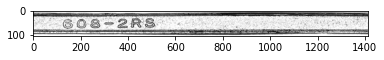

In [ ]:
def Average(lst):
  return sum(lst) / len(lst)

if __name__ == '__main__':
    center = (658, 531)  # Center of object to be unwrapped.
    outer_radius = 225  # Outer radius of object.
    inner_radius = 120
    circumference = int(2 * outer_radius * np.pi)  # calculate circumference of circle from radius variable.

    img = cv2.imread('bearing.bmp', 0)  # read image from file

    iterations = 100
    results = []
    for _ in range(iterations):
      t0 = time.perf_counter()  # time before executing
      polar = polar_remap(img, center, circumference, inner_radius, outer_radius, CCW = False, flip = False)  # polar unwrap function
      t1 = time.perf_counter()  # time after executing

      execution_time = t1 - t0 
      results.append(execution_time * 1000);
      #print("%.4f" % execution_time + "ms")  # print execution time to console. Sometimes execution is 0.0000ms due to caching?

    print("Iterations: " + str(iterations))
    print("Execution Time minimum (ms): " + str(min(results)))
    print("Execution Time maximum (ms): " + str(max(results)))
    print("Execution Time Average (ms): " + str(Average(results)))
    print("Execution Time Average(Trimmed) (ms): " + str(stats.trim_mean(results, 0.2)))

    cv2.imwrite("unwrap.png", polar, params=None)  # save unwrap image to file.
    plt.imshow(polar, cmap='gray')
    plt.show()  # show unwrapped image in new window.
    cv2.waitKey()  # wait for user input (keeps console open)